In [155]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import pandas as pd

from collections import Counter

from itertools import chain

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set(font_scale=1.5)

In [153]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import MultinomialNB,BernoulliNB

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet


from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

import re
import random
import nltk

In [3]:
df = pickle.load(open("dataframe.pickle", "rb" ) )

In [145]:
subs_list = list(df['substance'][df['num_subs'] == 1].unique())

In [151]:
# Create a list of tuples from the df, thanks to https://stackoverflow.com/questions/9758450/pandas-convert-dataframe-to-array-of-tuples
documents = list(df[['word_clean','tone']][df['tone'].isin(['Positive', 'Negative'])].itertuples(index=False, name=None))

## Shuffle for good measure
random.shuffle(documents)

## Create a big ole list of all words in the corpus for a freq count
all_words = list(chain.from_iterable(df['word_clean'][df['tone'].isin(['Positive', 'Negative'])].tolist()))

## Word counts, should do something fun with this if I've got time
all_words = nltk.FreqDist(all_words)

word_features = list(all_words.keys())[:3000]
print("Word features: ", len(word_features))

## Returns a featureset as a list of tuples of dictionaries
def find_features(documents):
    words = set(documents)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

featuresets = [(find_features(rev), category) for (rev, category) in documents]

## This does the same thing, but word_tokenizes its input. This is used for mucking around with new data.
def find_feats(document):
    words = clean_word_f(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

def clean_word_f(x):
    out = []
    x = word_tokenize(x.lower())
    for i in x:
        i = i.strip("'")
        if i not in stop_words and i not in subs_list and re.match(r'[a-z]', i) and len(i) >2:
            out.append(wnl.lemmatize(i, get_pos(i)))
    return out

def get_pos(word):
    w_synsets = wordnet.synsets(word)

    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )
    
    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0]


## And finally preparing our training and testing sets
split_len = int(round(len(featuresets) * .90, 0))
split_len

## Training and testing sets
training_set = featuresets[:split_len]
testing_set = featuresets[split_len:]
print("Training size: ", len(training_set))
print("Testing size: ", len(testing_set))

classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)

classifier.show_most_informative_features(15)

save_classifier = open("naivebayes.pickle","wb")
pickle.dump(classifier, save_classifier)
save_classifier.close()

Word features:  3000
Training size:  6318
Testing size:  702
Classifier accuracy percent: 73.07692307692307
Most Informative Features
               ambulance = True           Negati : Positi =     18.8 : 1.0
                softness = True           Positi : Negati =     10.9 : 1.0
                    muse = True           Positi : Negati =     10.4 : 1.0
                hospital = True           Negati : Positi =     10.2 : 1.0
                 backrub = True           Positi : Negati =      8.5 : 1.0
                    jail = True           Negati : Positi =      8.4 : 1.0
                   unity = True           Positi : Negati =      8.3 : 1.0
             application = True           Positi : Negati =      7.4 : 1.0
                   bound = True           Positi : Negati =      7.4 : 1.0
                empathic = True           Positi : Negati =      7.1 : 1.0
             contentment = True           Positi : Negati =      7.1 : 1.0
         non-threatening = True          

In [157]:
df['bayes_pred'] = df['word_clean'].apply(lambda x: classifier.classify(find_features(x)))


In [70]:
def predict_sent(x):
    if x > .33:
        return "Positive"
    elif x < -.33:
        return "Negative"
    else:
        return "Neutral"
df['vc_pred'] = df['vc_compound'].apply(lambda x: predict_sent(x))
df['vw_pred'] = df['vw_compound'].apply(lambda x: predict_sent(x))

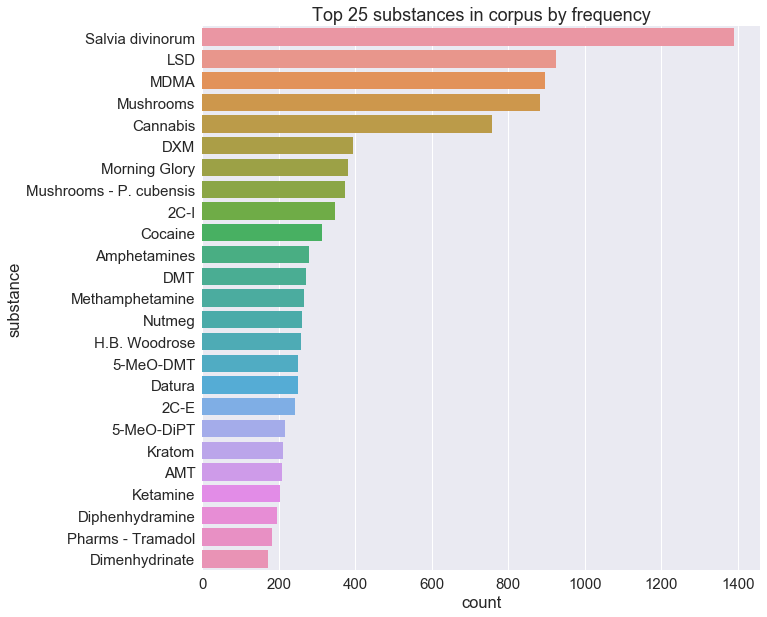

In [118]:
df = df[df['num_subs'] == 1]
top_25 = df['substance'].value_counts().reset_index()['index'][:25]
top_10 = df['substance'].value_counts().reset_index()['index'][:10]
# top_25
fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Top 25 substances in corpus by frequency')
sns.countplot(y = 'substance', data = df[df['substance'].isin(top_25)], order = top_25)

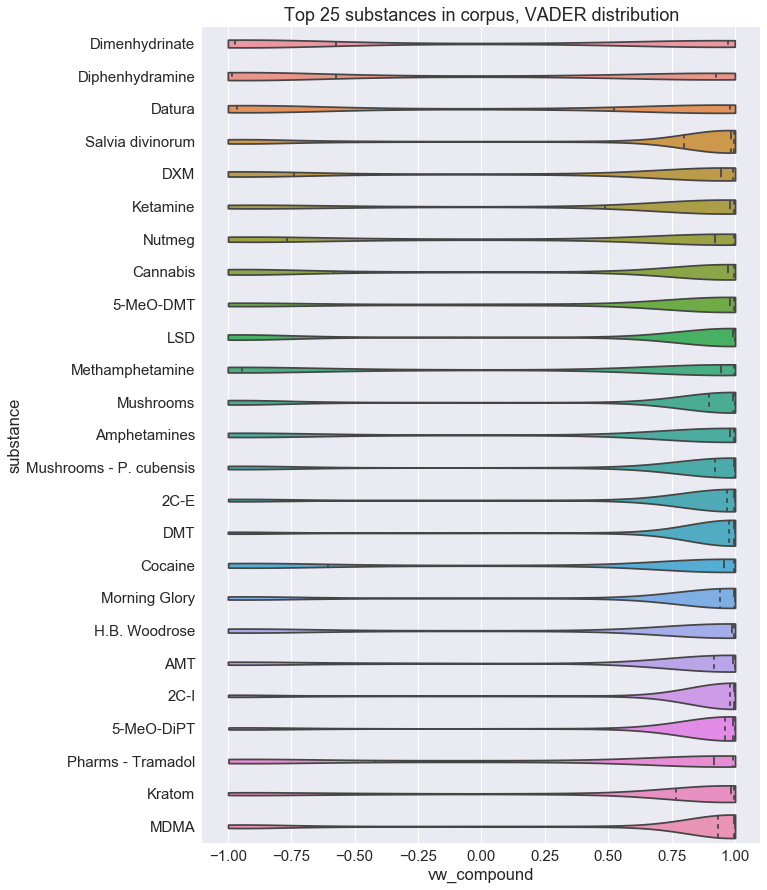

In [121]:
fig, ax = plt.subplots(figsize=(10, 15))
plt.title('Top 25 substances in corpus, VADER distribution')
sns.violinplot(x = 'vw_compound', y = 'substance', 
               data = df[df['substance'].isin(top_25)], 
               cut = 0,
               inner = "quartile",
               order = df[df['substance'].isin(top_25)].groupby('substance').median().reset_index().sort_values('vw_pos')['substance'])

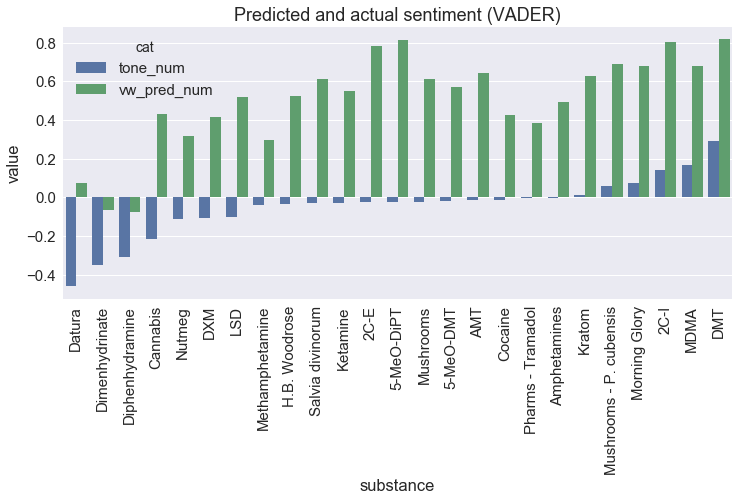

In [173]:
def cat_exp_num(x):
    if x == "Positive":
        return 1
    elif x == "Negative":
        return -1
    else:
        return 0

df['bayes_num'] = df['bayes_pred'].apply(lambda x: cat_exp_num(x))
df['tone_num'] = df['tone'].apply(lambda x: cat_exp_num(x))
df['vc_pred_num'] = df['vc_pred'].apply(lambda x: cat_exp_num(x))
df['vw_pred_num'] = df['vw_pred'].apply(lambda x: cat_exp_num(x))
agg_sub = df[df['substance'].isin(top_25)].groupby('substance')['tone_num', 'vc_pred_num', 'vw_pred_num', 'vw_neg', 'vw_neu', 'vw_pos', 'vw_compound', 'vc_neg', 'vc_neu', 'vc_pos', 'vc_compound', 'vc_pred', 'vw_pred', 'vc_acc', 'vw_acc', 'bayes_num'].mean().reset_index()
agg_melt = pd.melt(agg_sub, id_vars = ['substance'], var_name='cat')
agg_melt = agg_melt[agg_melt['cat'].isin(['tone_num', 'vw_pred_num'])]


fig, ax = plt.subplots(figsize=(12, 5))
plt.title('Predicted and actual sentiment (VADER)')
plt.xticks(rotation=90)
sns.barplot(x = 'substance', y = 'value', data = agg_melt[agg_melt['value'] != 0], hue = 'cat', order = agg_sub.sort_values('tone_num')['substance'])

# # agg_sub

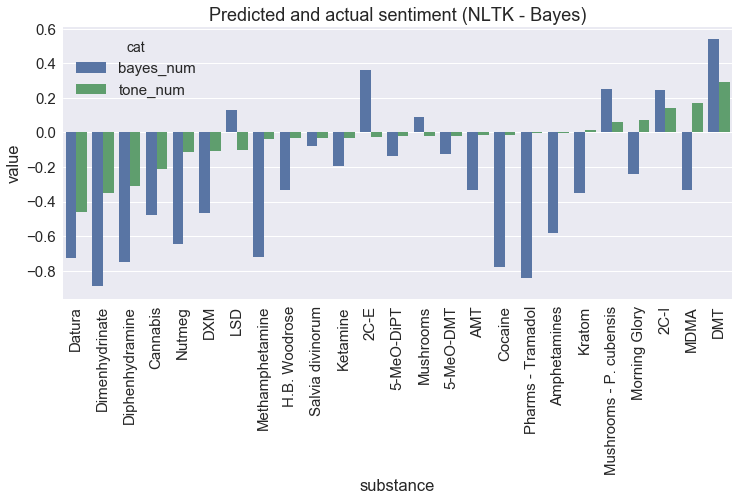

In [177]:
neu_bayes = df[df['tone_num'] == 0].groupby('substance')['bayes_num'].mean().reset_index()
neu_bayes = neu_bayes[neu_bayes['substance'].isin(top_25)]
neu_bayes = neu_bays.merge(agg_sub[['substance', 'tone_num']], left_on='substance', right_on='substance')

agg_melt = pd.melt(neu_bayes, id_vars = ['substance'], var_name='cat')
agg_melt = agg_melt[agg_melt['cat'].isin(['tone_num', 'bayes_num'])]


fig, ax = plt.subplots(figsize=(12, 5))
plt.title('Predicted and actual sentiment (NLTK - Bayes)')
plt.xticks(rotation=90)
sns.barplot(x = 'substance', y = 'value', data = agg_melt[agg_melt['value'] != 0], hue = 'cat', order = agg_sub.sort_values('tone_num')['substance'])



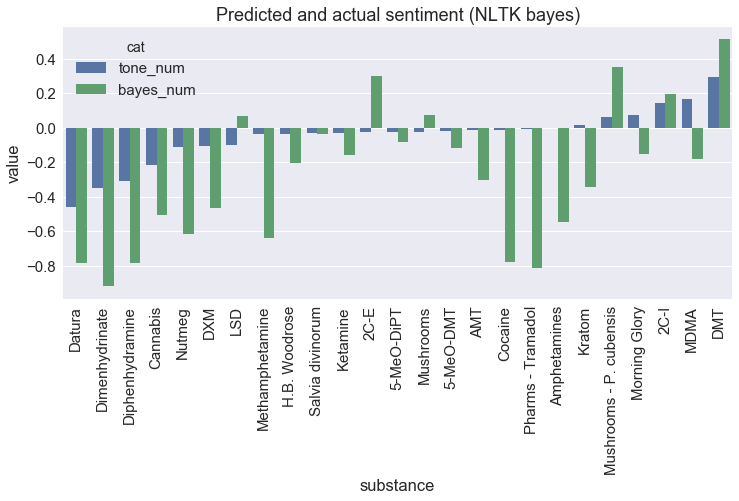

In [165]:
agg_melt = pd.melt(agg_sub, id_vars = ['substance'], var_name='cat')
agg_melt = agg_melt[agg_melt['cat'].isin(['tone_num', 'bayes_num'])]


fig, ax = plt.subplots(figsize=(12, 5))
plt.title('Predicted and actual sentiment (NLTK bayes)')
plt.xticks(rotation=90)
sns.barplot(x = 'substance', y = 'value', data = agg_melt[agg_melt['value'] != 0], hue = 'cat', order = agg_sub.sort_values('tone_num')['substance'])

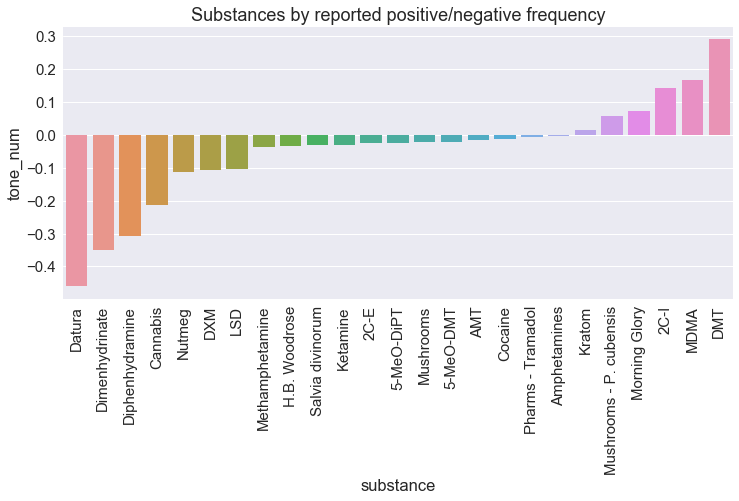

In [158]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.title('Substances by reported positive/negative frequency')
plt.xticks(rotation=90)
sns.barplot(x = 'substance', y = 'tone_num', data = agg_sub[agg_sub['tone_num'] != 0], order = agg_sub.sort_values('tone_num')['substance'])


Positive


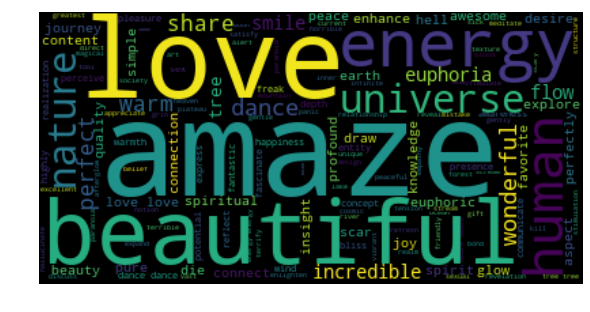

Negative


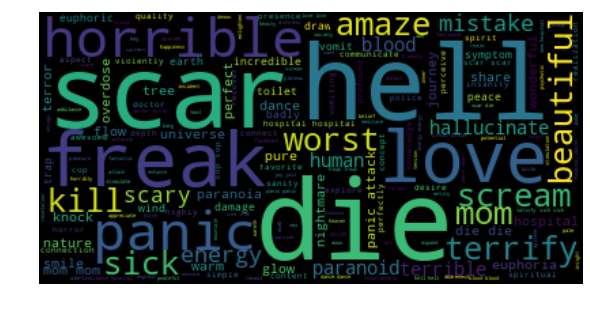

In [209]:
from wordcloud import WordCloud

feature_inf = pd.DataFrame(classifier.most_informative_features(600))
feature_inf = list(feature_inf[0])
feature_inf

for i in ["Positive", "Negative"]:
    print(i)
    text = df['word_clean'][df['tone'] == i]
    text = list(chain.from_iterable(text))
    text = [i for i in text if i in feature_inf]
    text = " ".join(text)
    
    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    # the matplotlib way:
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

#     # lower max_font_size
#     wordcloud = WordCloud(max_font_size=40).generate(text)
#     plt.figure()
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
    plt.show()

['ambulance',
 'softness',
 'muse',
 'hospital',
 'backrub',
 'jail',
 'unity',
 'application',
 'bound',
 'empathic',
 'contentment',
 'non-threatening',
 'dancefloor',
 'exquisite',
 'oneness',
 'nurse',
 'sensual',
 'snowball',
 'incorporate',
 'psychotic',
 'erection',
 'interconnectedness',
 'empathogen',
 'wigged',
 'throw-up',
 'fend',
 'pertain',
 'officer',
 'childlike',
 'bond',
 'buddha',
 'shitless',
 'nightmare',
 'geltabs',
 'tripsitter',
 'liberate',
 'enrapture',
 'galaxy',
 'evolution',
 'punish',
 'clot',
 'jealousy',
 'massage',
 'escort',
 'ecstatic',
 'suffuse',
 'forgetful',
 'preperations',
 'bliss',
 'police',
 'kidney',
 'delightful',
 'supreme',
 'congeal',
 'intelligible',
 'triviality',
 'mitsubishi',
 'reorganize',
 'worst',
 'blissfully',
 'orgasmic',
 'overdose',
 'religion',
 'beauty',
 'landscape',
 'spirituality',
 'horror',
 'synergistic',
 'magnesium',
 'percieve',
 'gift',
 'firework',
 'relized',
 'adolescence',
 'freon',
 'climax',
 'fullness',
 '